# Deep learning experiments on artificial generated signals

First we need to setup the environment and import all the necessary stuff.

In [129]:
%matplotlib inline

import logging

logging.basicConfig(level=40)
logger = logging.getLogger()

from neon.backends import gen_backend
from neon.layers import FCLayer, DataLayer, CostLayer
from neon.models import MLP
from neon.transforms import RectLin, Logistic, CrossEntropy
from neon.experiments import FitPredictErrorExperiment

import shutil
from os import remove
import cPickle as pkl
from os.path import expanduser, exists

Creation of an artificial dataset. We will use a sinus with added noise for now. Different classes will get different period lengths.

In [136]:
# Dataset creation

import logging
import numpy as np
import math
import random
from neon.datasets.dataset import Dataset

class GeneratedDS(Dataset):
    # for each example we will generate 400 inputs
    feature_count = 400

    # number of examples to generate
    num_train_examples = 3000
    num_test_examples = 1000

    num_labels = 32

    # To the underlying sinus courve we will add random noise with a maximum of noise_strength
    noise_strength = 5.0 / num_labels

    def period(self, label):
        return (label * 2.0 + 1) / self.num_labels * 10

    def sin_w_noise(self, x, period):
        noise = (random.random() - 0.5) * self.noise_strength
        return math.sin(x * 1.0 / period) + noise

    def generate_example(self,label):
        e = np.empty(self.feature_count)
        rand_offset = random.random() * (self.period(label) * math.pi * 2)
        for f in range(0, self.feature_count):
            e[f] = self.sin_w_noise(f + rand_offset, self.period(label))
        return e

    def generate_label(self):
        return random.randint(0, self.num_labels - 1)

    def generate_input(self, example_count):
        d = np.empty((example_count, self.feature_count), dtype=float)
        l = np.zeros((example_count, self.num_labels), dtype=float)
        for i in range(0, example_count):
            label = self.generate_label()
            l[i, label] = 1
            d[i, :] = self.generate_example(label)
        return d, l

    def load(self, **kwargs):

        # Generate training and test datasets
        (data, labels) = self.generate_input(self.num_train_examples)
        self.inputs['train'] = data
        self.targets['train'] = labels

        (data, labels) = self.generate_input(self.num_test_examples)
        self.inputs['test'] = data
        self.targets['test'] = labels

        if 'format_data' not in kwargs or kwargs['format_data']:
            self.format()
        
dataset = GeneratedDS()

Let's have a look at the generated data. We will plot some of the examples of the different classes.

[2011  143 2643]
11


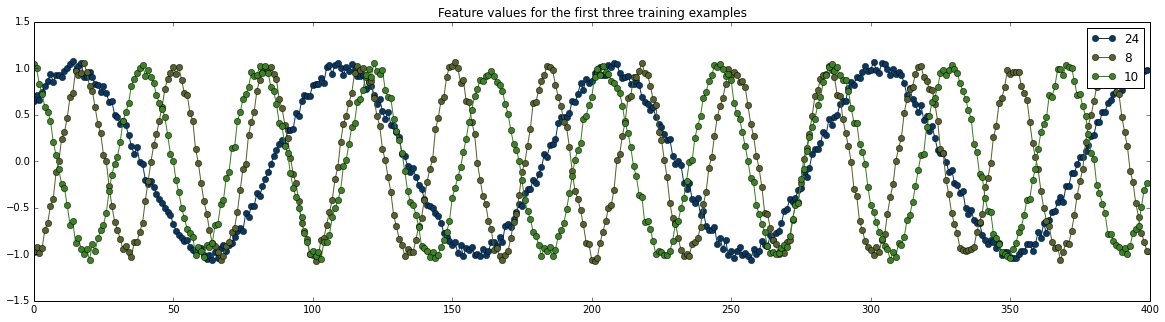

In [137]:
dataset.load(format_data=False)
from matplotlib import pyplot, cm

plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, 3)

print plot_ids

print np.where(dataset.targets['train'][i] == 1)[0][0]

def label_of_example(i):
    return np.where(dataset.targets['train'][i] == 1)[0][0]

pyplot.figure(figsize=(20,5))
for i in plot_ids:
    c = np.random.random((3,))
    pyplot.plot(range(0, dataset.feature_count), dataset.inputs['train'][i,], '-o', c=c)
    
pyplot.legend(map(label_of_example, plot_ids))
pyplot.title('Feature values for the first three training examples')
pyplot.show()

Now we are going to create a neon model. We will start with a multilayer preceptron having 4 hidden layers.

In [141]:
file_path = expanduser('~/data/signal-dl/signal-mlp.prm')
if exists(file_path):
    remove(file_path)
train_err = []
test_err = []
max_epochs = 10
batch_size = max(10, min(100, dataset.num_train_examples/10))

print 'Epochs: %d Batch-Size: %d' % (max_epochs, batch_size)

for num_epochs in range(0,max_epochs+1):
    # set up the layers
    layers = []
    layers.append(DataLayer(nout=dataset.feature_count))
    layers.append(FCLayer(nout=100, activation=RectLin()))
    layers.append(FCLayer(nout=50, activation=RectLin()))
    layers.append(FCLayer(nout=GeneratedDS.num_labels, activation=Logistic()))
    layers.append(CostLayer(cost=CrossEntropy()))

    # set up the model and experiment
    model = MLP(num_epochs=num_epochs, batch_size=batch_size, layers=layers,
                serialized_path=file_path, )
    # Uncomment line below to run on CPU backend
    backend = gen_backend(rng_seed=123)
    # Uncomment line below to run on GPU using cudanet backend
    # backend = gen_backend(rng_seed=0, gpu='cudanet')
    experiment = FitPredictErrorExperiment(model=model,
                                           backend=backend,
                                           dataset=dataset)

    # Run the training, and dump weights
    dest_path = expanduser('~/data/signal-dl/signal-ep' + str(num_epochs) + '.prm')
    print "Trained for max_epoch = " + str(num_epochs)
    if num_epochs > 0:
        res = experiment.run()
        train_err.append(res['train']['MisclassPercentage_TOP_1'])
        test_err.append(res['test']['MisclassPercentage_TOP_1'])
        # Save the weights at this epoch
        shutil.copy2(file_path, dest_path)

    else:
        params = layers[1].weights.asnumpyarray()
        pkl.dump(params, open(dest_path,'w'))



Epochs: 10 Batch-Size: 100
Trained for max_epoch = 0
Trained for max_epoch = 1
Trained for max_epoch = 2


Trained for max_epoch = 3


Trained for max_epoch = 4


Trained for max_epoch = 5


Trained for max_epoch = 6


Trained for max_epoch = 7


Trained for max_epoch = 8


Trained for max_epoch = 9


Trained for max_epoch = 10

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

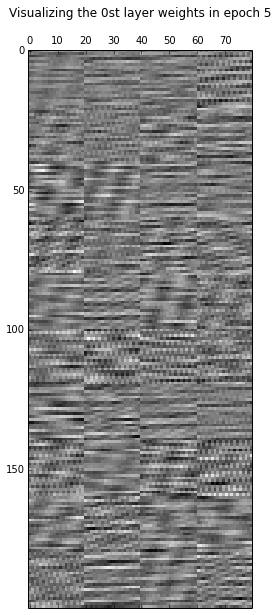

In [142]:
import numpy as np
from matplotlib import pyplot, cm
from IPython.html import widgets
from IPython.html.widgets import interact

nrows = 10
ncols = 4
fr = math.sqrt(dataset.feature_count)

def plot_filters(**kwargs):
    n = kwargs['n']
    dest_path = expanduser('~/data/signal-dl/signal-ep' + str(n) + '.prm')
    params = pkl.load(open(dest_path, 'r'))
    if n>0:
        wts = params['layer_1']['weights']
    else:
        wts = params

    fi = 0

    W = np.zeros((fr*nrows, fr*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fr*col:fr*(col+1)] = wts[fi].reshape(20,20)
        fi = fi + 1

    pyplot.matshow(W, cmap=cm.gray)
    pyplot.title('Visualizing the 0st layer weights in epoch ' + str(n) )
    pyplot.show()

_i = interact(plot_filters,
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs, value=0))

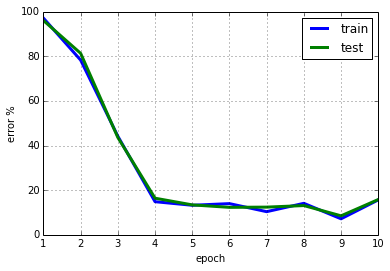

In [143]:
pyplot.plot(range(1, max_epochs+1), train_err, linewidth=3, label='train')
pyplot.plot(range(1, max_epochs+1), test_err, linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("error %")
pyplot.show()